In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram,linkage
from scipy.cluster.hierarchy import cut_tree
import datetime
from scipy.cluster.hierarchy import ward, fcluster
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer,InterclusterDistance

## Énoncé
Consultant pour Olist, nous devons fournir aux équipes d'e-commerce une segmentation des clients utilisable au quotidien pour leurs campagnes de communication.
## Mission
Nous allons réaliser différentes approches de modélisation pour regrouper des clients de profils similaires.

Lecture du jeu de données:

In [4]:
df_orders = pd.read_csv('df_orders.csv')

### Feature engineering

Nous allons créer des features utiles à notre problématique:

#### Les dates

Mettons tout dabord les dates au format correct:

Définissons une fonction qui effectue cette tache:

In [5]:
def datetime(df, columns):
    """Put the date in the right format.
    Parameters
    ----------
    df : dataframe
    columns:  list
            list of the features with dates
    Returns
    -------
    df : dataframe
    """
    for col in columns:
        df[col] = pd.to_datetime(df[col])
    return df

Mettons les features des dates au format correct:

In [8]:
columns_times = [
    'order_purchase_timestamp','order_approved_at',
    'review_answer_timestamp','review_creation_date',
    'order_delivered_carrier_date', 'order_delivered_customer_date', 
    'order_estimated_delivery_date', 'shipping_limit_date',
]
df = datetime(df_orders, columns_times)

 Créons la feature relative à la différence entre la date de livraison estimée et celle réelle de livraison:

In [9]:
df_orders['diff_delivered_days'] = (df_orders['order_estimated_delivery_date'] - \
                                    df_orders['order_delivered_customer_date']).dt.days

Visualissons la répartition des délais de livraisons:

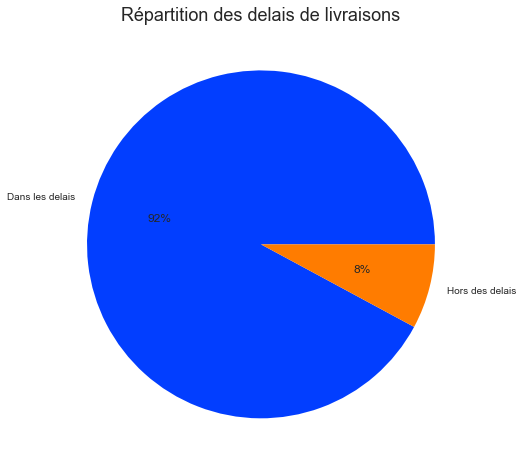

In [10]:
comptage_days = (df_orders['diff_delivered_days'] < 0).value_counts()
colors = sns.color_palette('bright')
plt.figure(figsize=(8, 8))
plt.pie(comptage_days.values, labels=['Dans les delais', 'Hors des delais'], colors=colors, autopct='%0.0f%%')
title = plt.title("Répartition des delais de livraisons" , fontsize=18)

92% des commandes sont livrées dans les delais.

#### Payement

Créons une feature pour calculer le payement total effectué par commande:

In [11]:
df_orders['total_payment'] = df_orders['payment_value']*df_orders['payment_installments']
df_orders['total_payment'].head()

0     18.12
1    113.31
2     37.77
3     44.09
4     83.69
Name: total_payment, dtype: float64

#### RFM

Dans le but de cibler les clients plus ou moins intéressants en terme de vente, nous allons créer trois features(RFM) relatives  à trois aspects importants d'un point de vue marketing:
- Récence : durée depuis la dernière commande, 
- Fréquence : nombre de commandes, 
- Montant: montant cumulé des commandes.

Prenons comme referentiel la derniére date de commandes:

In [12]:
max_date = max(df_orders['order_purchase_timestamp'])
max_date

Timestamp('2018-10-17 17:30:18')

Définissons une feature pour calculer de le nombre de jours écoulés depuis la dernière commande:

In [13]:
df_orders['nb_days'] = (max_date - df_orders['order_purchase_timestamp']).dt.days
df_orders['nb_days'].head()

0    380
1    427
2    440
3    358
4    433
Name: nb_days, dtype: int64

Définissons le dataframe des clients relatif aux features de récence, fréquence et montant des commandes effectuées:

In [14]:
df_rfm = df_orders.groupby('customer_unique_id').agg({'nb_days': 'min', 
                                                     'customer_id':'count', 
                                                      'total_payment':'sum'}).reset_index()
df_rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']
df_rfm.head()

,customer_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,1135.20
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19
2,0000f46a3911fa3c0805444483337064,585,1,689.76
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,174.48
4,0004aac84e0df4da2b147fca70cf8255,336,1,1181.34


#### Analyse bivariée des feature RFM

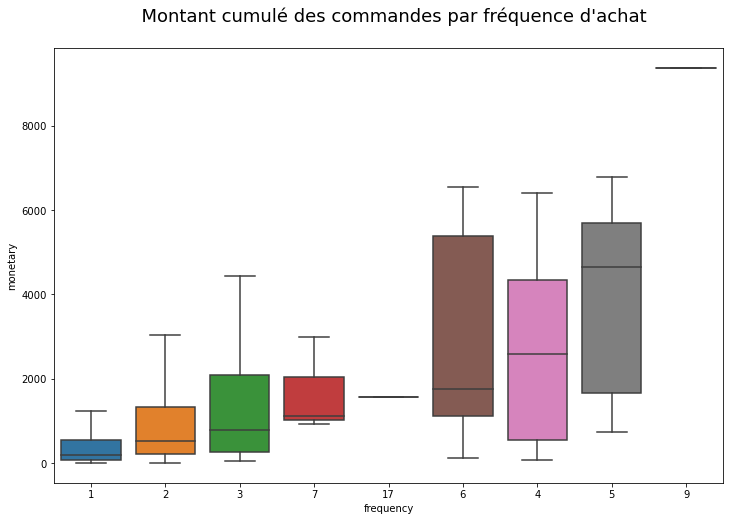

In [10]:
ordre = df_rfm.groupby('frequency')['monetary'].median().sort_values().index
plt.figure(figsize=(12,8))
ax = sns.boxplot( y="monetary",x="frequency", showfliers=False, order=ordre, data=df_rfm)
ax.set_xlabel("frequency")
ax.set_ylabel("monetary")
title = plt.title("  Montant cumulé des commandes par fréquence d'achat" "\n", fontsize=18)

Les clients ayant passé une seule commande sont ceux en moyenne ayant le plus bas montant de commande.Ceux  en revanche ayant passés 9 commandes sont ceux ayant le montant de commandes le plus élevé.

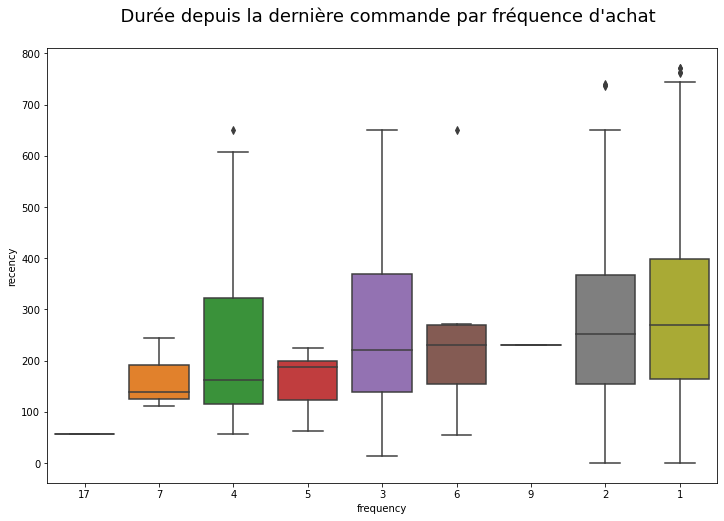

In [11]:
ordre = df_rfm.groupby('frequency')['recency'].median().sort_values().index
plt.figure(figsize=(12,8))
ax = sns.boxplot( y="recency",x="frequency", showfliers=True, order=ordre, data=df_rfm)
ax.set_xlabel("frequency")
ax.set_ylabel("recency")
title = plt.title("  Durée depuis la dernière commande par fréquence d'achat" "\n", fontsize=18)

En géneral les clients ayant effectués plusieurs commandes(17) sont ceux en moyenne les plus recents clients.

###  Clustering avec l'algorithme KMEANS 

#### RFM segmentation 

Nous allons utliser l’algorithme k-means pour le clustering des clients relatifs features RFM, avec pour objectif de déterminer des clusters utiles d’un point de vue métier marketing :

Standardissons les données:

In [15]:
df_rfm_scaled = df_rfm[['monetary', 'frequency', 'recency']]
scaler = StandardScaler()
df_rfm_scaled = scaler.fit_transform(df_rfm_scaled)

Afin de déterminer le nombre optimal de clusters, nous allons utiliser la méthode de coude et le coefficient de silhouette:

##### Méthode du coude

Définissons une fonction pour afficher le graphe relatif à la methode de coude:

In [11]:
def elbow_method(df):
    """Yellowbrick's KElbowVisualizer implements the “elbow” method of selecting the optimal
    number of clusters by fitting the K-Means model with a range of values for K and draw the data.
    Parameters
    ----------
    df : dataframe
    """
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2,15))
    visualizer.fit(df)  
    visualizer.poof()    

Pour déterminer le nombre ideal de clusters, nous allons examiner le pourcentage de variance expliquée en fonction du nombre de cluster

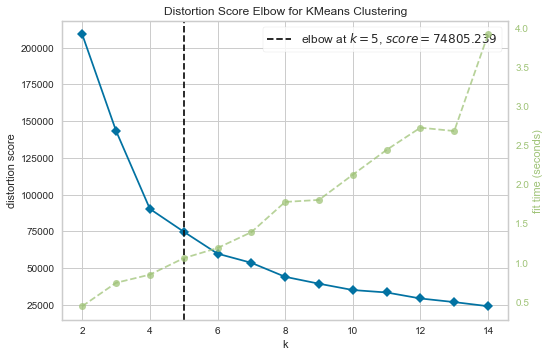

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [45]:
elbow_method(df_rfm_scaled) 

Il en découle qu'au dela de 5 clusters,l'ajout d'un autre cluster ne donne pas une bien meilleure modélisation des données.

##### Coefficient de silhouette 

Définissons une fonction pour calculer le coefficient de sihouette:

In [17]:
def silhouette(df):
    """KElbowVisualizer setted with the silhouette scoring parameter metric for selecting the optimal
    number of clusters by fitting the K-Means model with a range of values for K and draw the data.
    Parameters
    ----------
    df : dataframe
    """
    model=model = KMeans()
    visualizer = KElbowVisualizer(model, k=(3,15), metric="silhouette", timings=False)
    visualizer.fit(df) 
    visualizer.poof() 

Nous allons déterminer de nombre optimal de cluster en comparant les coefficients de silhouette :

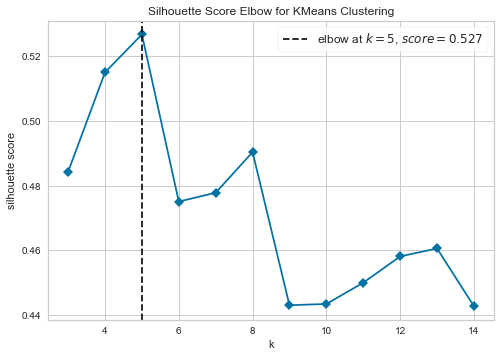

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [48]:
silhouette(df_rfm_scaled)

Les valeurs  du nombres de clusters candidats sont entre 3 et 8 avec entre ces valeurs peu de différence du coefficient de silhouette.

#### Analyses des clusters

Pour un nombre k de clusters donné, définissons une fonction qui calcule le nombre de clients par cluster:

In [16]:
def nbre_clients_cluster(df, k, df_scaled):
    """Calculation of the number of customers per cluster and assignment 
    the values in a column created.
    Parameters
    ----------
    df : dataframe
    k : integer
        number of clusters
    df_scaled: array
               dataframe values scaled
    Returns
    -------
    df : dataframe
    """
    kmeans = KMeans(n_clusters=k, max_iter=50)
    kmeans.fit(df_scaled)
    df['cluster_id'] = kmeans.labels_
    return df

Définissons une fonction pour afficher la répartition des clients par clusters:

In [18]:
def display_nbres_clients(df, i, j, df_scaled):
    """Display of the number of customers per cluster.
    Parameters
    ----------
    df : dataframe
    i : integer
         minimum number of clusters
    j : integer
        maximum number of clusters
    df_scaled: array
               dataframe values scaled
    """          
    for k in range(i,j):
        df = nbre_clients_cluster(df, k, df_scaled)
        n = df.groupby('cluster_id').agg({'customer_id': 'count'})
        print("Répartion du nombre des clients pour {} clusters:\n{}".format(k, n))

Affichons les répartitions des clients pour k(entre 3 et 8) clusters données:

In [19]:
display_nbres_clients(df_rfm, 3, 9, df_rfm_scaled)

Répartion du nombre des clients pour 3 clusters:
            customer_id
cluster_id             
0                 39393
1                 53706
2                  2997
Répartion du nombre des clients pour 4 clusters:
            customer_id
cluster_id             
0                  2952
1                 39028
2                 52391
3                  1725
Répartion du nombre des clients pour 5 clusters:
            customer_id
cluster_id             
0                 51538
1                 38262
2                   374
3                  2968
4                  2954
Répartion du nombre des clients pour 6 clusters:
            customer_id
cluster_id             
0                 21377
1                 34146
2                  2786
3                  2967
4                 34454
5                   366
Répartion du nombre des clients pour 7 clusters:
            customer_id
cluster_id             
0                 21350
1                 34553
2                  2718
3          

A plus de 4 clusters, on trouve des clusters avec un nombre de clients inferieur à 500 et donc pas pertinent d’un point de vue métier.

Le nombre de clusters retenu  est donc 3 et 4.

##### Clustering avec 3 clusters

Définissons le dataframe relatif à 3 clusters:

In [119]:
df_rfm_3 = nbre_clients_cluster(df_rfm, 3, df_rfm_scaled)

In [13]:
df_rfm_3.head()

,customer_id,recency,frequency,monetary,cluster_id
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,1135.20,2
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,2
2,0000f46a3911fa3c0805444483337064,585,1,689.76,0
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,174.48,0
4,0004aac84e0df4da2b147fca70cf8255,336,1,1181.34,0


Définissons deux fonctions qui affichent la densité de séparation entre les clusters et la distance interclusters:

In [13]:
def silhouette_visualizer(df,k):
     """The SilhouetteVisualizer displays the silhouette coefficient 
     for each sample on a per-cluster basis, for visualize the density 
     and separation of the clusters.
    Parameters
    ----------
    df : dataframe
    k : integer
        number of clusters
    """
    model = KMeans(k)
    visualizer = SilhouetteVisualizer(model)
    visualizer.fit(df) 
    visualizer.poof()

In [14]:
def distance_visualizer(df,k):
    """distance_visualizer display an embedding of the 
    cluster centers in 2 dimensions with the distance 
    to other centers preserved.
    Parameters
    ----------
    df : dataframe
    k : integer
        number of clusters
    """
    distance_visualizer=InterclusterDistance(KMeans(k))
    distance_visualizer.fit(df)
    distance_visualizer.poof()

Affichons la distance interclusters:

C:\Users\33624\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:517: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


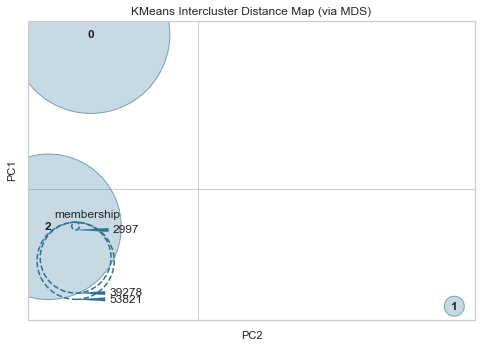

In [125]:
distance_visualizer(df_rfm_scaled,3)

Visualissons la densité de séparation entre clusters:

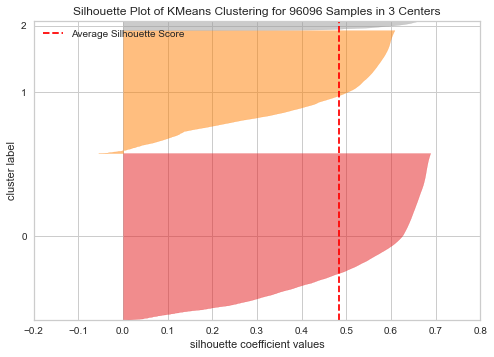

In [64]:
silhouette_visualizer(df_rfm_scaled,3)

Affichons  la moyenne par cluster per feature RFM:

In [20]:
df_mean = df_rfm_3.groupby('cluster_id').agg({'customer_id': 'count',
                                            'recency': 'mean',
                                            'frequency': 'mean',
                                            'monetary': 'mean'})
df_mean.columns = ['count', 'recency_mean', 'frequency_mean',' monetary_mean']
df_mean

,count,recency_mean,frequency_mean,monetary_mean
cluster_id,,,,
0,53778,178.294191,1.000000,602.510918
1,2997,268.206874,2.116116,1336.442249
2,39321,438.903588,1.000000,726.079124


Affichons les distrubutions des features RFM par cluster:

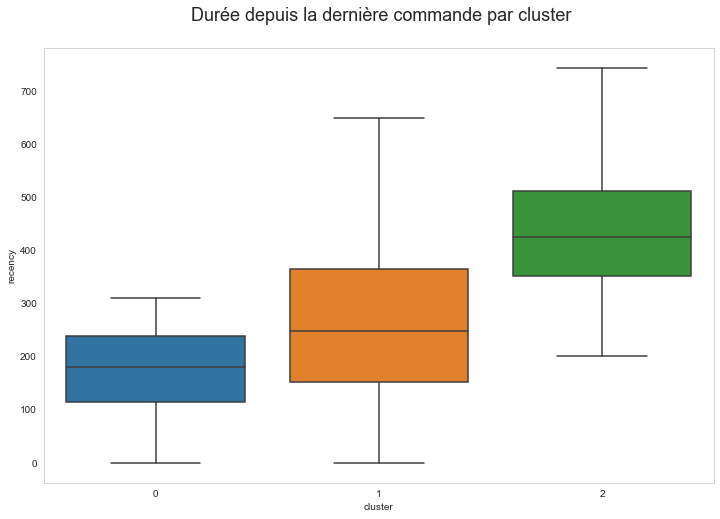

In [21]:
ordre_recency = df_rfm_3.groupby('cluster_id')['recency'].median().sort_values().index
plt.figure(figsize=(12,8))
ax = sns.boxplot(x="cluster_id", y="recency", showfliers=False, order=ordre_recency, data=df_rfm_3)
ax.set_xlabel("cluster")
ax.set_ylabel("recency")
title = plt.title(" Durée depuis la dernière commande par cluster" "\n", fontsize=18)

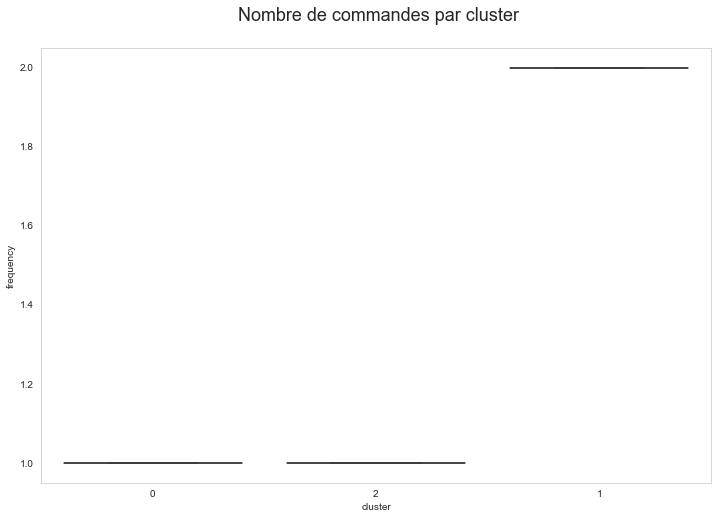

In [22]:
ordre_recency = df_rfm_3.groupby('cluster_id')['frequency'].median().sort_values().index
plt.figure(figsize=(12,8))
ax=sns.boxplot(x="cluster_id", y="frequency", showfliers=False, order=ordre_recency, data=df_rfm_3)
ax.set_xlabel("cluster")
ax.set_ylabel("frequency")
title = plt.title(" Nombre de commandes par cluster" "\n", fontsize=18)

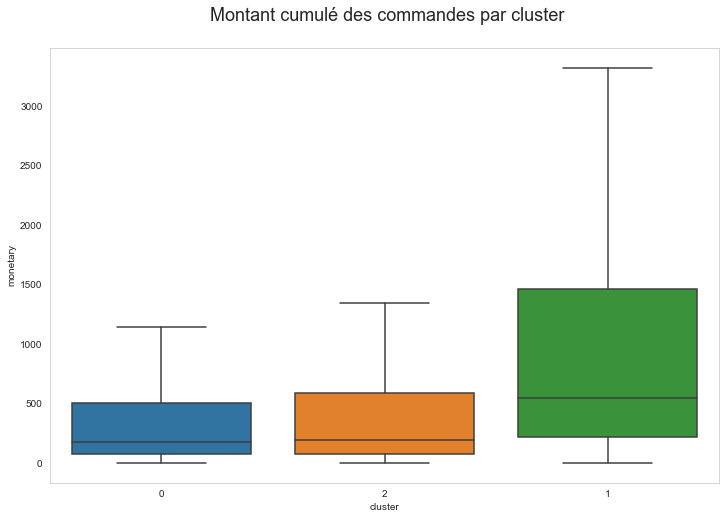

In [23]:
ordre_recency = df_rfm_3.groupby('cluster_id')['monetary'].median().sort_values().index
plt.figure(figsize=(12,8))
ax = sns.boxplot(x="cluster_id", y="monetary", showfliers=False, order=ordre_recency, data=df_rfm_3)
ax.set_xlabel("cluster")
ax.set_ylabel("monetary")
title = plt.title(" Montant cumulé des commandes par cluster" "\n", fontsize=18)

Il en ressort que:
- Le cluster 1 represente les clients ayant  des montants de commandes élevés et une fréquence de commande élevée.
- Le cluster 2 et  represente les clients ayant effectués une seule commande avec une date de derniére commande assez eloignée. 
- Le cluster 0 quant à lui represente layant effectués une seule commande avec une date de derniére commande assez récente.

##### Clustering avec 4 clusters

Définissons le dataframe relatif à 4 clusters:

In [17]:
df_rfm_4 = nbre_clients_cluster(df_rfm, 4, df_rfm_scaled)

In [30]:
df_rfm_4.head()

,customer_id,recency,frequency,monetary,cluster_id
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,1135.20,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,1
2,0000f46a3911fa3c0805444483337064,585,1,689.76,0
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,174.48,0
4,0004aac84e0df4da2b147fca70cf8255,336,1,1181.34,0


Visualissons la distance interclusters:

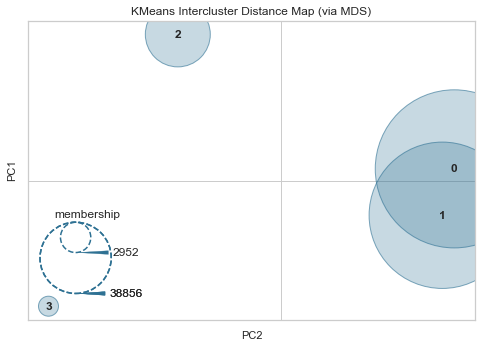

In [129]:
distance_visualizer(df_rfm_scaled, 4)

Visualissons la densité de séparation entre clusters:

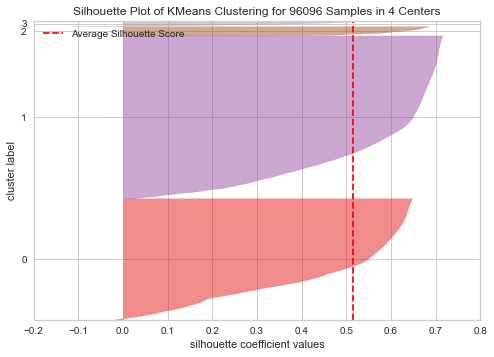

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 96096 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [50]:
silhouette_visualizer(df_rfm_scaled, 4)

Affichons la moyenne par cluster per feature RFM:

In [26]:
df_mean = df_rfm_4.groupby('cluster_id').agg({'customer_id': 'count',
                                            'recency': 'mean',
                                            'frequency': 'mean',
                                            'monetary': 'mean'})
df_mean.columns = ['count', 'recency_mean', 'frequency_mean', 'monetary_mean']
df_mean

,count,recency_mean,frequency_mean,monetary_mean
cluster_id,,,,
0,39028,437.451061,1.000000,503.948998
1,52391,177.122559,1.000000,458.985845
2,2952,267.638889,2.116531,1097.141982
3,1725,294.325217,1.028406,10436.924487


Affichons les distrubutions des features RFM par cluster:

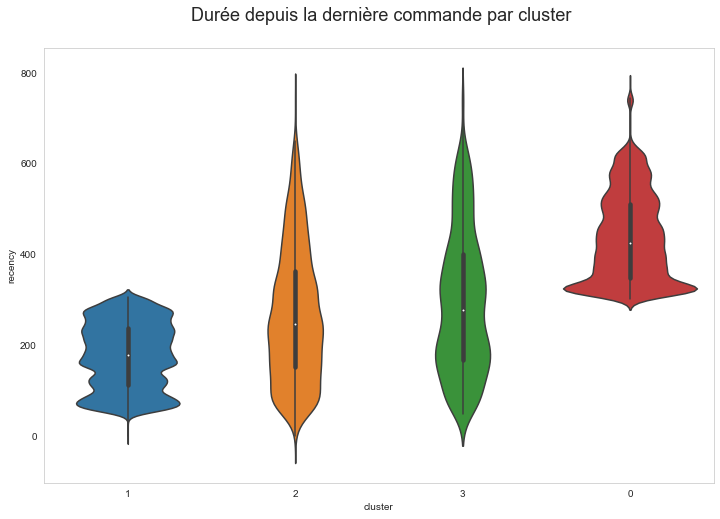

In [27]:
ordre_recency = df_rfm_4.groupby('cluster_id')['recency'].median().sort_values().index
plt.figure(figsize=(12,8))
ax = sns.violinplot(x="cluster_id", y="recency", showfliers=False, order=ordre_recency, data=df_rfm_4)
ax.set_xlabel("cluster")
ax.set_ylabel("recency")
title = plt.title(" Durée depuis la dernière commande par cluster" "\n", fontsize=18)

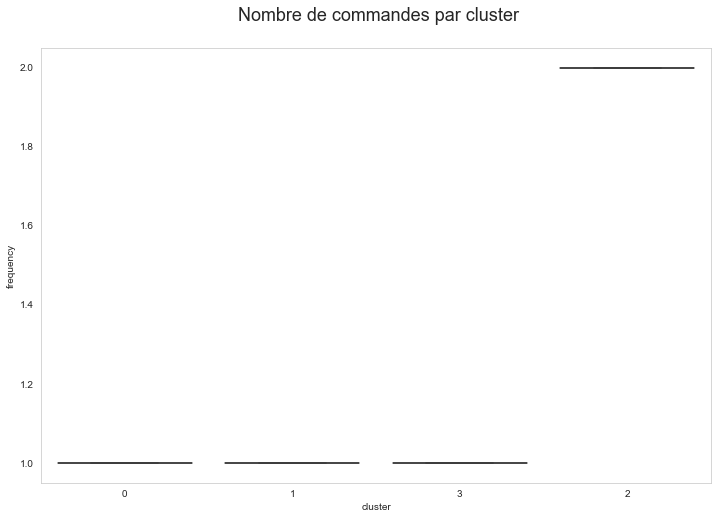

In [28]:
ordre_recency = df_rfm_4.groupby('cluster_id')['frequency'].median().sort_values().index
plt.figure(figsize=(12,8))
ax = sns.boxplot(x="cluster_id", y="frequency", showfliers=False, order=ordre_recency, data=df_rfm_4)
ax.set_xlabel("cluster")
ax.set_ylabel("frequency")
title = plt.title(" Nombre de commandes par cluster" "\n", fontsize=18)

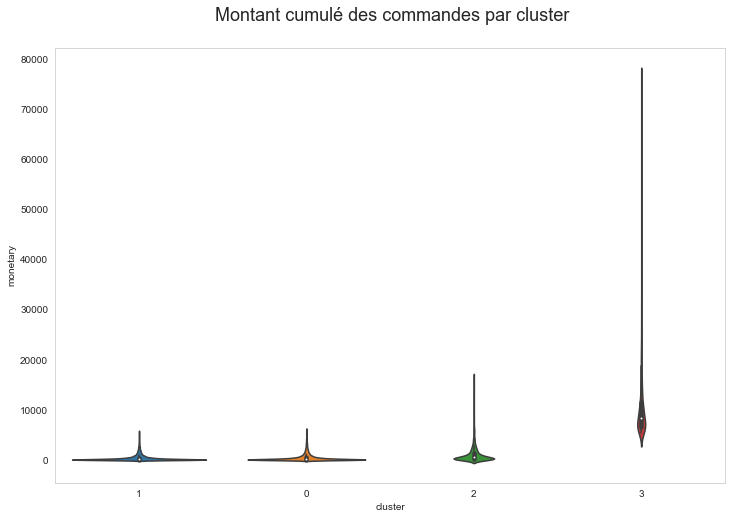

In [29]:
ordre_recency = df_rfm_4.groupby('cluster_id')['monetary'].median().sort_values().index
plt.figure(figsize=(12,8))
ax = sns.violinplot(x="cluster_id", y="monetary", showfliers=False, order=ordre_recency, data=df_rfm_4)
ax.set_xlabel("cluster")
ax.set_ylabel("monetary")
title = plt.title(" Montant cumulé des commandes par cluster" "\n", fontsize=18)

Il en ressort que:
- Le cluster 3 represente les clients ayant effectués une commande et ayant des montants de commandes les plus élevés.
- Le cluster 2 et  represente les clients ayant effectués  plus d'une  commande.
- Le cluster 0 quant à lui represente les clients ayant effectués une seule commande avec une date de derniére commande assez eloignée.
- Le cluster 1 quant à lui represente les clients ayant effectués une seule commande avec une date de derniére commande la plus récente.

Le clustering avec 4 clusters nous semble celui qui segmente le mieux nos clients.

#### Ajout de Review_score 

Afin d'avoir plus d'informations nous permettant de segmenter nos clients,nous allons ajouter la feature Review_score relative aux notes de satisfaction des clients.

Définissons le nouveau dataframe:

In [20]:
df_rfm_score = df_orders.groupby('customer_unique_id').agg({'nb_days': 'min',
                                                           'customer_id':'count',
                                                           'total_payment':'sum',
                                                           'review_score': 'mean'
                                                           }).reset_index()
df_rfm_score.columns = ['customer_id', 'recency', 'frequency', 'monetary', 'note']
df_rfm_score.head()

,customer_id,recency,frequency,monetary,note
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,1135.20,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,4.0
2,0000f46a3911fa3c0805444483337064,585,1,689.76,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,174.48,4.0
4,0004aac84e0df4da2b147fca70cf8255,336,1,1181.34,5.0


Standardissons les données:

In [21]:
df_rfm_score_scaled = df_rfm_score[['recency', 'frequency', 'monetary', 'note']]
scaler = StandardScaler()
df_rfm_score_scaled = scaler.fit_transform(df_rfm_score_scaled)

Affichons le graphe relatif à la méthode de coude:

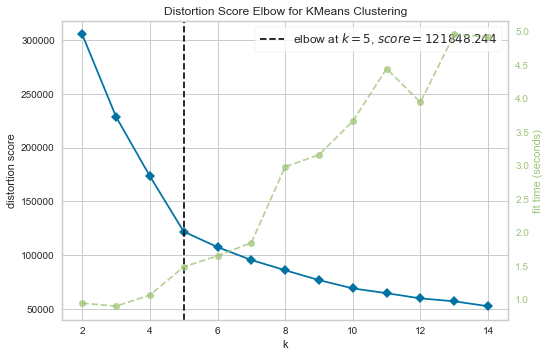

In [15]:
elbow_method(df_rfm_score_scaled)

Il en découle qu'au dela de 5 clusters, l'ajout d'un autre cluster ne donne pas une bien meilleure modélisation des données.

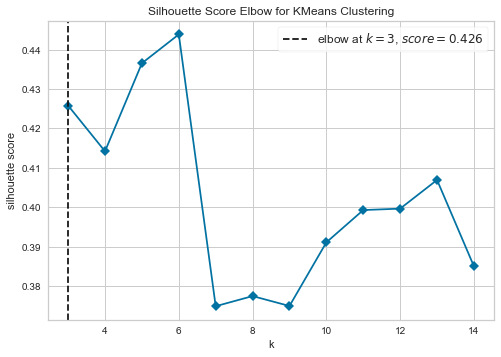

In [18]:
silhouette(df_rfm_score_scaled)

Les valeurs du nombre de clusters offrant de meilleurs coefficient de silhouette sont entre 3 et 6.

Affichons les répartitions des clients par clusters:

In [22]:
display_nbres_clients(df_rfm_score, 3, 8, df_rfm_score_scaled)

Répartion du nombre des clients pour 3 clusters:
            customer_id
cluster_id             
0                 71875
1                 21224
2                  2997
Répartion du nombre des clients pour 4 clusters:
            customer_id
cluster_id             
0                 17114
1                 32619
2                  2997
3                 43366
Répartion du nombre des clients pour 5 clusters:
            customer_id
cluster_id             
0                  1574
1                 42603
2                 32132
3                  2952
4                 16835
Répartion du nombre des clients pour 6 clusters:
            customer_id
cluster_id             
0                 42153
1                  2958
2                 16643
3                 31530
4                   356
5                  2456
Répartion du nombre des clients pour 7 clusters:
            customer_id
cluster_id             
0                 29704
1                  2338
2                  2958
3          

Au dela de 5 clusters, on trouve des clusters avec un nombre de clients inferieur à 500 et donc pas pertinent d’un point de vue métier.

Le nombre de clusters retenu est donc 4 et 5.

##### Clustering avec 4 clusters

In [15]:
df_rfm_score_4 = nbre_clients_cluster(df_rfm_score, 4, df_rfm_score_scaled)

Visualissons la distance interclusters:

C:\Users\33624\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:517: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(


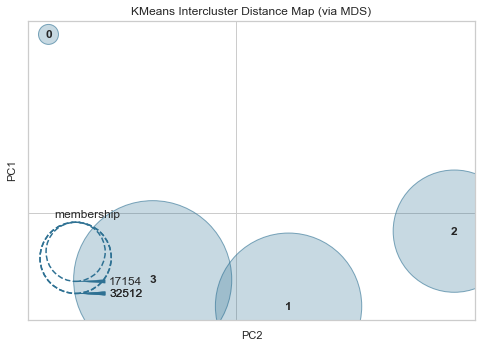

In [73]:
distance_visualizer(df_rfm_score_scaled, 4)

Affichons la moyenne des notes par cluster:

In [16]:
df_mean = df_rfm_score_4.groupby('cluster_id').agg({'customer_id': 'count',
                                                    'recency': 'mean',
                                                    'frequency':'mean',
                                                    'monetary':'mean',
                                                    'note': 'mean'})
df_mean.columns = ['count', 'recency_mean', 'frequency_mean', 'monetary_mean','note_mean']
df_mean

,count,recency_mean,frequency_mean,monetary_mean,note_mean
cluster_id,,,,,
0,43314,171.125664,1.000000,579.649705,4.671723
1,32635,442.167244,1.000000,672.065446,4.635545
2,17150,291.788222,1.000000,811.206192,1.587055
3,2997,268.206874,2.116116,1336.442249,4.129043


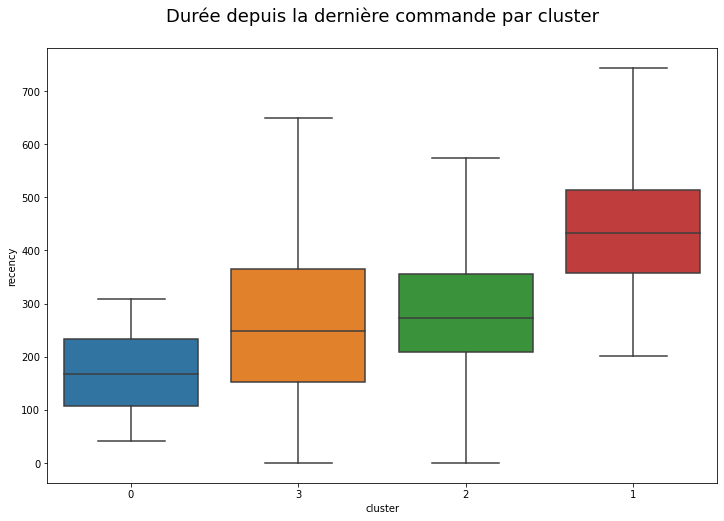

In [17]:
ordre = df_rfm_score_4.groupby('cluster_id')['recency'].mean().sort_values().index
plt.figure(figsize=(12,8))
ax = sns.boxplot(x="cluster_id", y='recency', showfliers=False, order=ordre, data=df_rfm_score_4)
ax.set_xlabel("cluster")
ax.set_ylabel("recency")
title = plt.title("Durée depuis la dernière commande par cluster" "\n", fontsize=18)

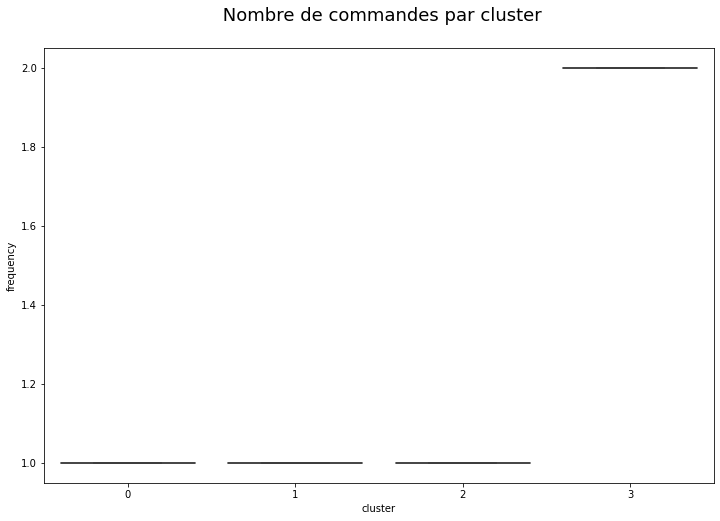

In [18]:
ordre = df_rfm_score_4.groupby('cluster_id')['frequency'].mean().sort_values().index
plt.figure(figsize=(12,8))
ax = sns.boxplot(x="cluster_id", y='frequency', showfliers=False, order=ordre, data=df_rfm_score_4)
ax.set_xlabel("cluster")
ax.set_ylabel("frequency")
title = plt.title("Nombre de commandes par cluster" "\n", fontsize=18)

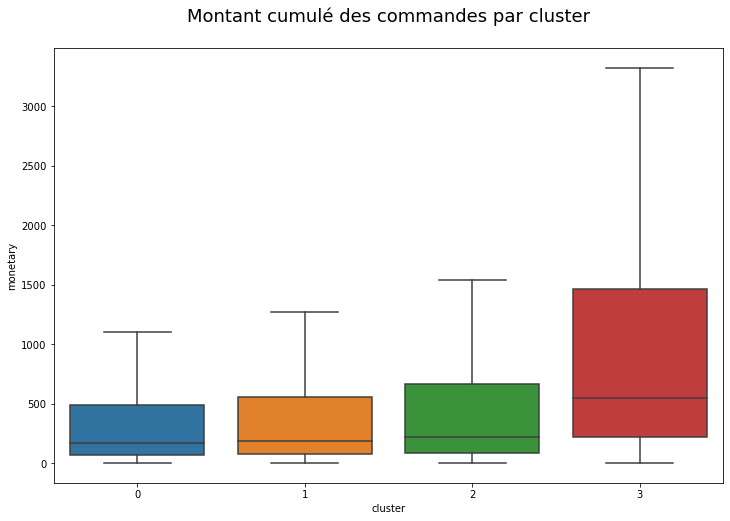

In [19]:
ordre = df_rfm_score_4.groupby('cluster_id')['monetary'].mean().sort_values().index
plt.figure(figsize=(12,8))
ax=sns.boxplot(x="cluster_id", y='monetary', showfliers=False, order=ordre, data=df_rfm_score_4)
ax.set_xlabel("cluster")
ax.set_ylabel("monetary")
title = plt.title("Montant cumulé des commandes par cluster" "\n", fontsize=18)

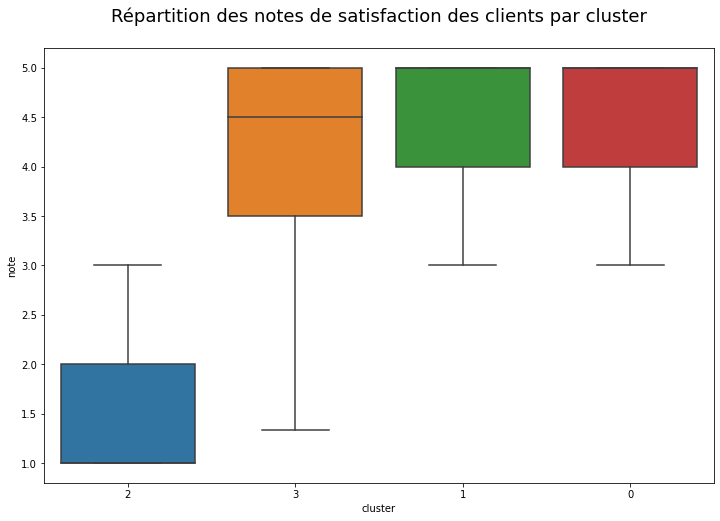

In [39]:
ordre = df_rfm_score_4.groupby('cluster_id')['note'].mean().sort_values().index
plt.figure(figsize=(12,8))
ax = sns.boxplot(x="cluster_id", y='note', showfliers=False, order=ordre, data=df_rfm_score_4)
ax.set_xlabel("cluster")
ax.set_ylabel("note")
title = plt.title("Répartition des notes de satisfaction des clients par cluster" "\n", fontsize=18)

#### Conclusion:

Il en ressort que:
- Le cluster 2 represente les clients mécontents et ayant effectués une commande mais ayant du potentiel sur point de vue économique 
- Le cluster 0 represente les clients satistaits de leurs commandes et ayant effectuées une commande,des montants de commandes les plus bas et une date de derniére commande la plus récente.
- Le cluster 1 represente les clients satisfaits leurs commandes et ayant effectués une commande et la date de commande la plus eloignée.
- Le cluster 3 represente les clients satisfaits de leurs commandes et ayant effectués plus d'une commandes et un montant de commande les plus élevés.

##### Clustering avec 5 clusters

In [40]:
df_rfm_score_5 = nbre_clients_cluster(df_rfm_score, 5, df_rfm_score_scaled)

Visualissons la distance interclusters:

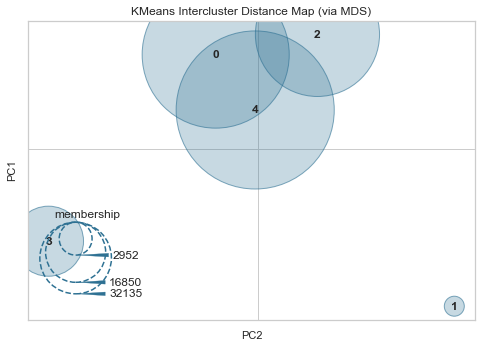

In [77]:
distance_visualizer(df_rfm_score_scaled, 5)

Affichons la moyenne des features par cluster:

In [41]:
df_mean = df_rfm_score_5.groupby('cluster_id').agg({'customer_id': 'count',
                                                  'recency': 'mean',
                                                  'frequency':'mean',
                                                  'monetary':'mean',
                                                  'note': 'mean'})
df_mean.columns = ['count', 'recency_mean', 'frequency_mean', 'monetary_mean', 'note_mean']
df_mean

,count,recency_mean,frequency_mean,monetary_mean,note_mean
cluster_id,,,,,
0,16850,291.534955,1.000000,562.146540,1.593353
1,32135,441.922421,1.000000,497.317009,4.635195
2,1574,296.916773,1.031131,10885.279333,3.970140
3,2952,267.638889,2.116531,1097.141982,4.132027
4,42585,170.935564,1.000000,449.258252,4.672490


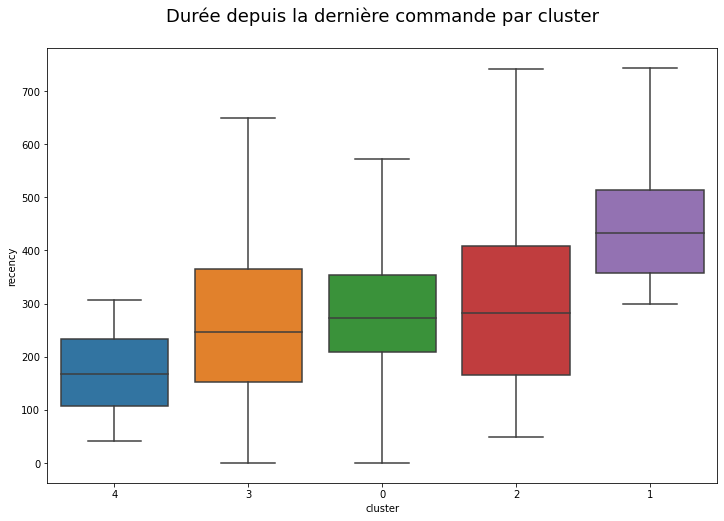

In [42]:
ordre = df_rfm_score_5.groupby('cluster_id')['recency'].mean().sort_values().index
plt.figure(figsize=(12,8))
ax = sns.boxplot(x="cluster_id", y='recency', showfliers=False, order=ordre, data=df_rfm_score_5)
ax.set_xlabel("cluster")
ax.set_ylabel("recency")
title = plt.title("Durée depuis la dernière commande par cluster" "\n", fontsize=18)

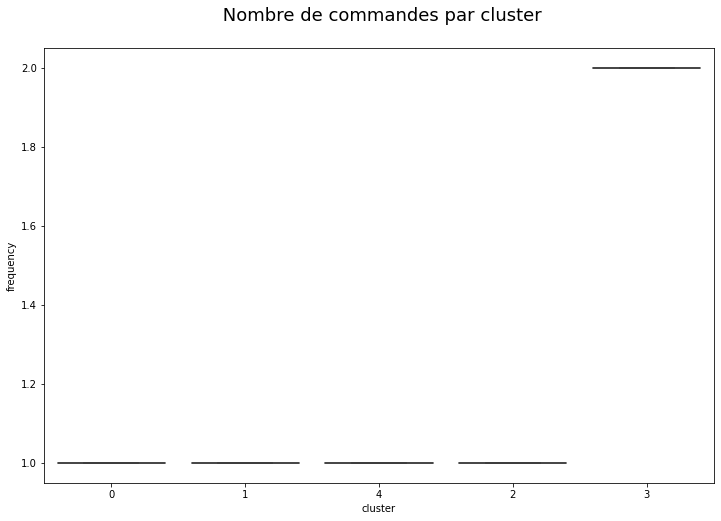

In [45]:
ordre = df_rfm_score_5.groupby('cluster_id')['frequency'].mean().sort_values().index
plt.figure(figsize=(12,8))
ax = sns.boxplot(x="cluster_id", y='frequency', showfliers=False, order=ordre, data=df_rfm_score_5)
ax.set_xlabel("cluster")
ax.set_ylabel("frequency")
title = plt.title(" Nombre de commandes par cluster" "\n", fontsize=18)

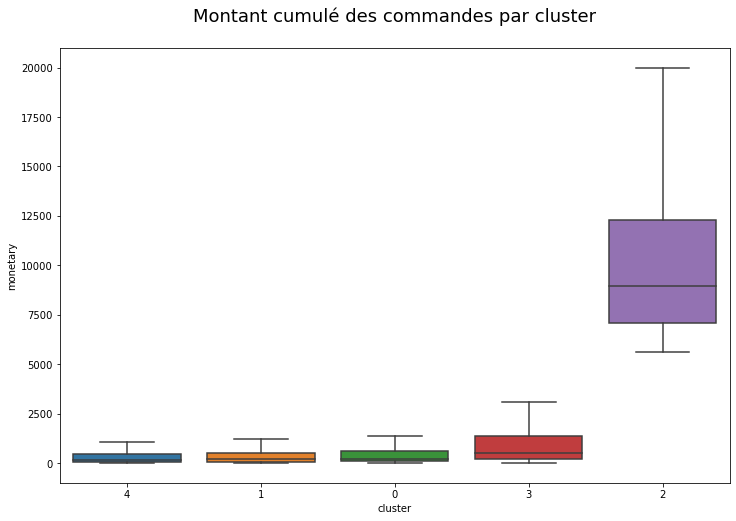

In [47]:
ordre = df_rfm_score_5.groupby('cluster_id')['monetary'].mean().sort_values().index
plt.figure(figsize=(12,8))
ax=sns.boxplot(x="cluster_id", y='monetary', showfliers=False, order=ordre, data=df_rfm_score_5)
ax.set_xlabel("cluster")
ax.set_ylabel("monetary")
title = plt.title("Montant cumulé des commandes par cluster" "\n", fontsize=18)

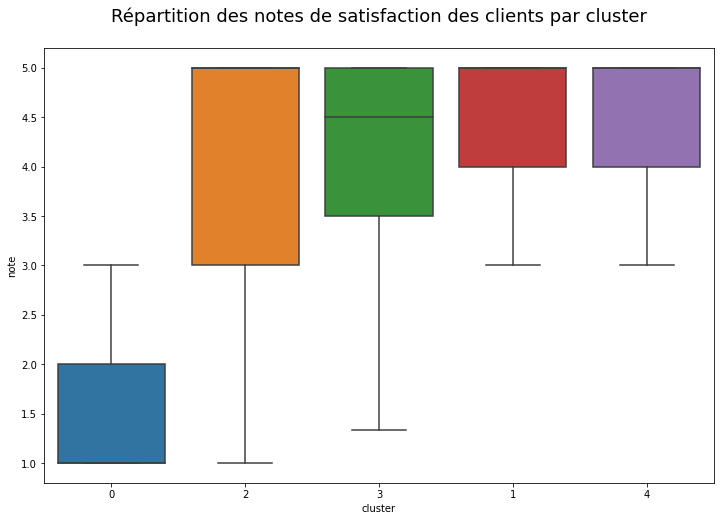

In [48]:
ordre = df_rfm_score_5.groupby('cluster_id')['note'].mean().sort_values().index
plt.figure(figsize=(12,8))
ax = sns.boxplot(x="cluster_id", y='note', showfliers=False,order=ordre, data=df_rfm_score_5)
ax.set_xlabel("cluster")
ax.set_ylabel("note")
title = plt.title("Répartition des notes de satisfaction des clients par cluster" "\n", fontsize=18)

#### Conclusion:

Il en ressort que:
- Le cluster 1 les clients très satistaits de leurs commandes, ayant effectués une commande , le montant de commande le plus bas et la date dernière commande la plus eloignée.
- Le cluster 2 represente les clients  satistaits de leurs commandes, ayant effectués une commande et un fort potentiel du point de vue économique.
- Le cluster 4 represente les clients  trés satistaits de leurs commandes, ayant effectués une commande et la date de la dernière commande la plus récente.
- Le cluster 0 represente les clients mécontents de leurs commandes et ayant effectués une commande.
- Le cluster 3 represente les clients satistaits de leurs commandes , ayant effectués plus d'une commande et du potentiel sur le point économique.

Le clustering avec 5 clusters nous semble celui segmentant le mieux nos clients.

#### Ajout de payment installments 

Afin d'avoir plus d'informations nous permettant de segmenter nos clients,nous allons ajouter la feature  relative aux nombres de tranche de payements des clients.

Définissons le nouveau dataframe:

In [28]:
df_rfm_payment = df_orders.groupby('customer_unique_id').agg({'nb_days': 'min',
                                                              'customer_id':'count',
                                                              'total_payment':'sum',
                                                              'review_score': 'mean',
                                                              'payment_installments': 'mean'}).reset_index()
df_rfm_payment.columns =['customer_id', 'recency', 'frequency', 'monetary','note', 'payment_installments']
df_rfm_payment.head()

,customer_id,recency,frequency,monetary,note,payment_installments
0,0000366f3b9a7992bf8c76cfdf3221e2,160,1,1135.20,5.0,8.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,1,27.19,4.0,1.0
2,0000f46a3911fa3c0805444483337064,585,1,689.76,3.0,8.0
3,0000f6ccb0745a6a4b88665a16c9f078,369,1,174.48,4.0,4.0
4,0004aac84e0df4da2b147fca70cf8255,336,1,1181.34,5.0,6.0


Standardissons les données:

In [29]:
df_rfm_payment_scaled = df_rfm_payment[['recency','frequency','monetary','note','payment_installments']]
scaler = StandardScaler()
df_rfm_payment_scaled = scaler.fit_transform(df_rfm_payment_scaled)

Affichons le graphe relatif à la méthode de coude:

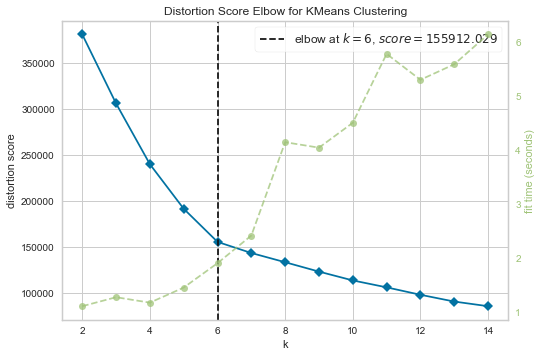

In [25]:
elbow_method(df_rfm_payment_scaled)

Il en découle qu'au dela de 6 clusters,l'ajout d'un autre cluster ne donne pas une bien meilleure modélisation des données.

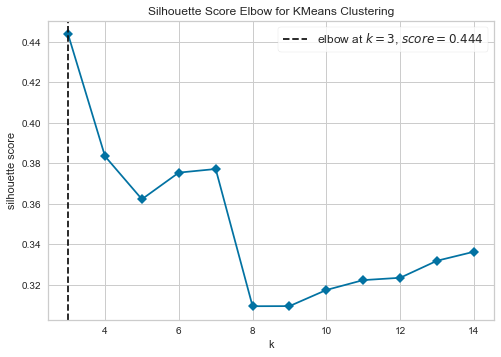

In [26]:
silhouette(df_rfm_payment_scaled)

Les valeurs du nombre de clusters offrant de meilleurs coefficient de silhouette sont entre 3 et 7.

Affichons le nombre de clients par clusters:

In [25]:
display_nbres_clients(df_rfm_payment, 3, 8, df_rfm_payment_scaled)

Répartion du nombre des clients pour 3 clusters:
            customer_id
cluster_id             
0                 79603
1                 13508
2                  2985
Répartion du nombre des clients pour 4 clusters:
            customer_id
cluster_id             
0                 11712
1                 62567
2                 18835
3                  2982
Répartion du nombre des clients pour 5 clusters:
            customer_id
cluster_id             
0                 15412
1                 38620
2                 28422
3                  2982
4                 10660
Répartion du nombre des clients pour 6 clusters:
            customer_id
cluster_id             
0                 12023
1                 37619
2                  1079
3                  2954
4                 27337
5                 15084
Répartion du nombre des clients pour 7 clusters:
            customer_id
cluster_id             
0                 26755
1                 37016
2                 15068
3          

A dela de 6 clusters, on trouve des clusters avec un nombre de clients inferieur à 500 et donc pas pertinent d’un point de vue métier.

Le nombre de clusters retenu est 5.

##### Clustering avec 5 clusters

In [53]:
df_rfm_payment_5 = nbre_clients_cluster(df_rfm_payment, 5, df_rfm_payment_scaled)

Affichons les moyennes par clusters:

In [54]:
df_mean = df_rfm_payment_5.groupby('cluster_id').agg({'customer_id': 'count',
                                                      'recency': 'mean',
                                                      'frequency':'mean',
                                                      'monetary':'mean',
                                                      'note': 'mean',
                                                      'payment_installments':'mean'})
df_mean.columns =['count', 'recency_mean', 'frequency_mean', 'monetary_mean', 'note_mean', 'payment_installments_mean']
df_mean

,count,recency_mean,frequency_mean,monetary_mean,note_mean,payment_installments_mean
cluster_id,,,,,,
0,15365,290.363488,1.000000,369.018396,1.580345,2.358737
1,2982,267.826962,2.116700,1217.249088,4.128519,3.232877
2,28417,443.130978,1.000000,285.456614,4.635254,2.180913
3,10688,297.415138,1.001403,3490.181837,4.151057,8.879491
4,38644,171.279578,1.000000,265.050675,4.672006,1.971690


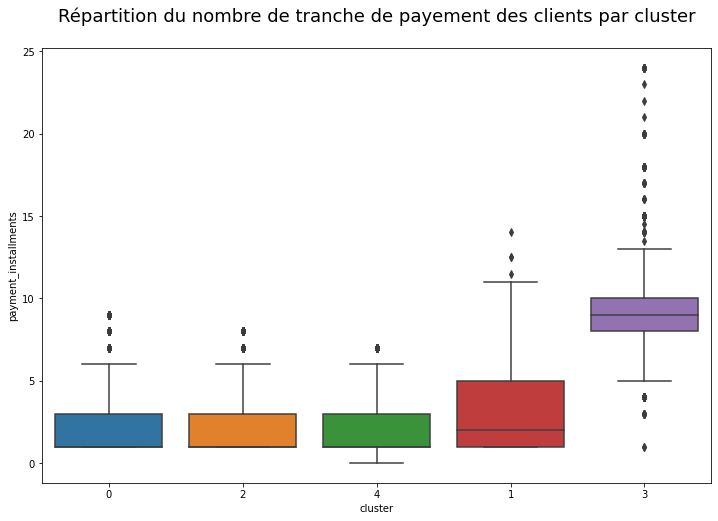

In [55]:
ordre = df_rfm_payment.groupby('cluster_id')['payment_installments'].median().sort_values().index
plt.figure(figsize=(12,8))
ax = sns.boxplot(x="cluster_id", y='payment_installments', showfliers=True, order=ordre, data=df_rfm_payment)
ax.set_xlabel("cluster")
ax.set_ylabel("payment_installments")
title = plt.title("Répartition du nombre de tranche de payement des clients par cluster" "\n", fontsize=18)

#### Conclusions:

Il en ressort que 5 les clusters retenus précedemment ne se trouvent pas boulversés, on les retrouve avec l'ajout de l'information relative au tranche de payement des clients. Il en ressort donc que:
- Le cluster 2 les clients très satistaits de leurs commandes, ayant effectués une commande , le montant de commande le plus bas et la date dernière commande la plus eloignée,ces derniers effectuent en moyenne deux versements de payement.
- Le cluster 3 represente les clients  satistaits de leurs commandes, ayant effectués une commande et un fort potentiel du point de vue économique,ces derniers effectuent en moyenne huit versements de payement.
- Le cluster 4 represente les clients  trés satistaits de leurs commandes, ayant effectués une commande et la date de la dernière commande la plus récente,ces derniers effectuent en moyenne deux versements de payement
- Le cluster 0 represente les clients mécontents de leurs commandes et ayant effectués une commande,ces derniers effectuent en moyenne deux versements de payement
- Le cluster 1 represente les clients satistaits de leurs commandes , ayant effectués plus d'une commande et du potentiel sur le point économique ,ces derniers effectuent en moyenne trois versements de payement.

### Clustering avec l'algorithme DBSCAN

Appliquons l'algorithme DBSCAN sur données des clients relatif au fichier RFM:

Afin d'avoir des clusters intéressants d'un point de vue métier,nous allons fixer l'hyperparamètre min_samples=500 et faire varier l'hyperparamètre eps:

In [30]:
min_samples=500
eps_values=np.arange(0.025,1,0.2)
eps_values

array([0.025, 0.225, 0.425, 0.625, 0.825])

 Définissons une fonction qui calcule la répartition des clients par clusters:

In [31]:
def dbscan_clusters(df, df_scaled):
     """Display of the number of customers per cluster using DBSCAN algorithm.
    Parameters
    ----------
    df : dataframe
    df_scaled: array
               dataframe values scaled
    """  
    for p in eps_values:
        DBS_clustering = DBSCAN(eps=p, min_samples=500).fit(df_scaled)
        df['cluster_id'] = DBS_clustering.labels_
        d=df.groupby('cluster_id').agg({'customer_id': 'count'})
        print("Répartion du nombre des clients par clusters pour eps={} et min_samples={}:\n{}"\
              .format(round(p,3), min_samples,d))

Affichons la répartitions par clusters:

In [32]:
dbscan_clusters(df_rfm_payment,df_rfm_payment_scaled)

Répartion du nombre des clients par clusters pour eps=0.025 et min_samples=500:
            customer_id
cluster_id             
-1                96096
Répartion du nombre des clients par clusters pour eps=0.225 et min_samples=500:
            customer_id
cluster_id             
-1                44501
 0                 8651
 1                26595
 2                 3670
 3                 6032
 4                 2280
 5                 3222
 6                  548
 7                  597
Répartion du nombre des clients par clusters pour eps=0.425 et min_samples=500:
            customer_id
cluster_id             
-1                21661
 0                14454
 1                46719
 2                 5092
 3                 7345
 4                  825
Répartion du nombre des clients par clusters pour eps=0.625 et min_samples=500:
            customer_id
cluster_id             
-1                12225
 0                51513
 1                15856
 2                 8550
 3      

Pour les différentes valeurs de eps nous n'obtenons pas un nombre de clusters intéressants.Les clusters obtenus ne contiennent pas tous un nombre suffisant de clients(inférieurs à 500) et donc pas pertinent d'un point de vue métier et le nombre de clients sans cluster (cluster « -1 ») est assez élevé.

Le clustering par DBSCAN n’est pas approprié pour notre analyse du fait que le DBSCAN fonctionnant par densité, dans notre cas la densité des 3000 bons clients (qui ont commandé plusieurs fois) est faible.

### CAH(classification ascendante hiérarchique) sur un echantillon

Appliquons la CAH sur données des clients relatif au fichier RFM:

Le dataset etant assez volumineux(plus 96000 observations),et par soucis de temps de traitement, nous décidons de travailler avec un echantillon du fichier.

In [13]:
df_rfm_payment_sample = df_rfm_payment.sample(n=50000)

Standardissons les données:

In [14]:
df_rfm_payment_sample_scaled = df_rfm_payment_sample[['monetary', 'frequency', 'recency', 'note', 'payment_installments']]
scaler = StandardScaler()
df_rfm_payment_sample_scaled = scaler.fit_transform(df_rfm_payment_sample_scaled)

Affichons le dendogramme:

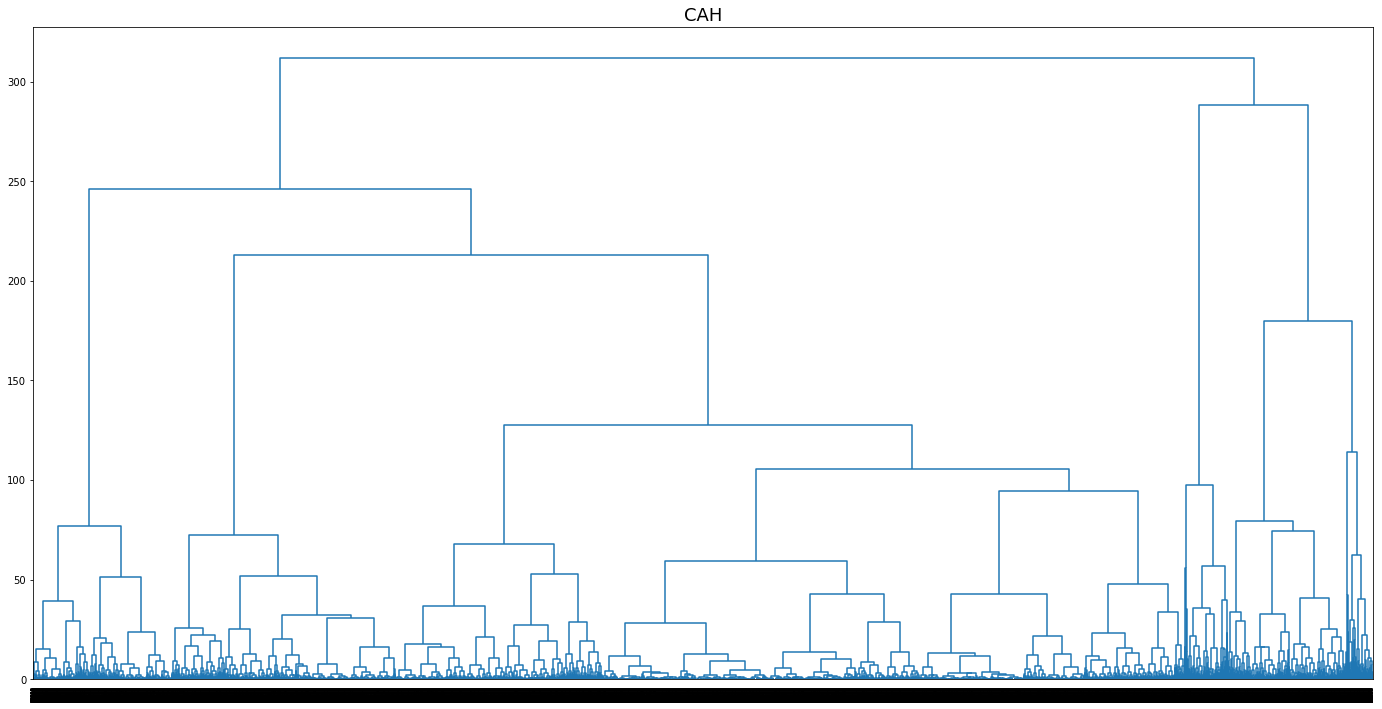

In [16]:
# Generate the link matrix
Z = linkage(df_rfm_payment_sample_scaled,method='ward',metric='euclidean')

# dendrogram display
plt.figure(figsize =(24, 12))
plt.title("CAH",fontsize=18)
dendrogram(Z,color_threshold=0)
plt.show()

Le dendrogramme « suggérait » un découpage ideale en 5 groupes.

Analysons les différentes segmentations entre 3 et 6:

In [ ]:
ac3 = AgglomerativeClustering(n_clusters = 3)
agrup3 = ac3.fit_predict(df_rfm_payment_sample_scaled) 
ac4 = AgglomerativeClustering(n_clusters = 4)
agrup4 = ac4.fit_predict(df_rfm_payment_sample_scaled) 
ac5 = AgglomerativeClustering(n_clusters = 5)
agrup5 = ac5.fit_predict(df_rfm_payment_sample_scaled) 
ac6 = AgglomerativeClustering(n_clusters = 6)
agrup6 = ac6.fit_predict(df_rfm_payment_sample_scaled) 

Calculons les differents coefficients de silhouette:

In [ ]:
silhouette_scores = []
silhouette_scores.append(
        silhouette_score(df_rfm_payment_sample_scaled, agrup3))
silhouette_scores.append(
        silhouette_score(df_rfm_payment_sample_scaled, agrup4))
silhouette_scores.append(
        silhouette_score(df_rfm_payment_sample_scaled, agrup5))
silhouette_scores.append(
        silhouette_score(df_rfm_payment_sample_scaled, agrup6))

Affichons les différents coefficients de sihouettes:

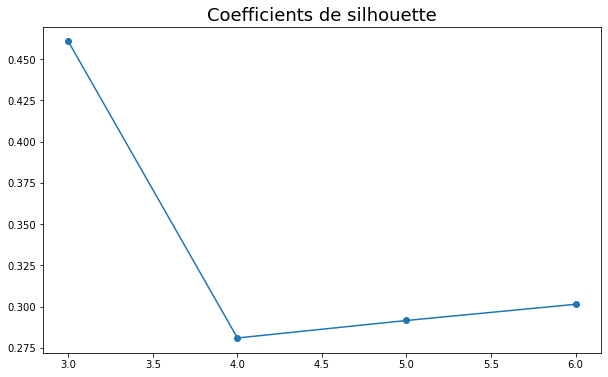

In [36]:
plt.figure(figsize = (10,6))
fig = plt.plot(range(3,7), silhouette_scores, marker='o')
title = plt.title("Coefficients de silhouette", fontsize=18)

Définissons une fonction qui calcule la répartition des clients par clusters:

In [37]:
def aglomerative_clusters(df,agrup,k):
     """Display of the number of customers per cluster using aglomerative clustering.
    Parameters
    ----------
    df : dataframe
    agrup : model
            aglomarative clustering model fitted
    k : integer
        number of clusters
    """  
    df['cluster_id'] = agrup
    n = df.groupby('cluster_id').agg({'customer_id': 'count'})
    print("Répartion du nombre des clients pour {} clusters:\n{}".format(k, n))

Affichons le nombre de clients par clusters:

In [40]:
aglomerative_clusters(df_rfm_payment_sample, agrup3, 3), aglomerative_clusters(df_rfm_payment_sample, agrup4, 4),
aglomerative_clusters(df_rfm_payment_sample, agrup5, 5), aglomerative_clusters(df_rfm_payment_sample, agrup6, 6)

Répartion du nombre des clients pour 3 clusters:
            customer_id
cluster_id             
0                 42359
1                  6040
2                  1601
Répartion du nombre des clients pour 4 clusters:
            customer_id
cluster_id             
0                 31358
1                  6040
2                  1601
3                 11001
Répartion du nombre des clients pour 5 clusters:
            customer_id
cluster_id             
0                  6040
1                 11001
2                  1601
3                 18275
4                 13083
Répartion du nombre des clients pour 6 clusters:
            customer_id
cluster_id             
0                 11001
1                 18275
2                  1601
3                  5718
4                 13083
5                   322


(None, None)

Au delà de 5 clusters, on trouve des clusters avec un nombre de clients inferieur à 500 et donc pas pertinent d’un point de vue métier.

Les clients semblent mieux répartis dans une subdivision à 5 clusters.

#### Matérialisation des 5 classes (hauteur t = 200)

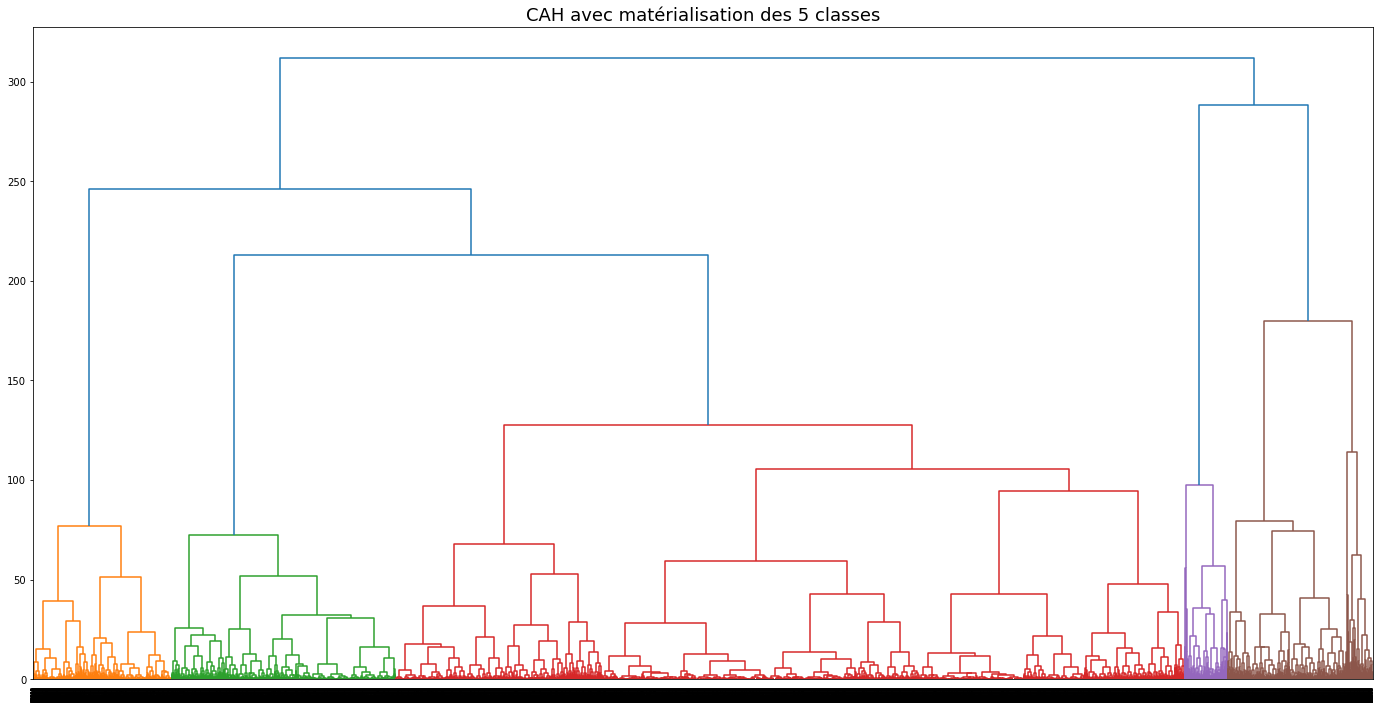

In [17]:
plt.figure(figsize=(24, 12))
plt.title('CAH avec matérialisation des 5 classes', fontsize=18)
dendrogram(Z, color_threshold=200)
plt.show()

Affichons la repartiton des clients  sur 5 clusters:

In [68]:
agglo_clustering = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
agrup = agglo_clustering.fit_predict(df_rfm_payment_sample_scaled) 
df_rfm_payment_sample['cluster_id'] = agrup
df_mean = df_rfm_payment_sample.groupby('cluster_id').agg({'customer_id': 'count',
                                                           'recency': 'mean',
                                                           'frequency': 'mean',
                                                           'monetary': 'mean',
                                                           'note': 'mean',
                                                           'payment_installments':'mean'})
df_mean.columns = ['count', 'recency_mean', 'frequency_mean', 'monetary_mean','note_mean', 'payment_installments_mean']
df_mean

,count,recency_mean,frequency_mean,monetary_mean,note_mean,payment_installments_mean
cluster_id,,,,,,
0,4721,278.690532,1.001483,3547.526009,4.489939,8.839653
1,20950,176.433031,1.000000,242.871867,4.463055,1.853556
2,1522,270.302234,2.106439,1148.820539,4.129211,3.202648
3,7140,317.272409,1.000000,684.594125,1.356863,3.436555
4,15667,429.247335,1.000000,337.495081,4.712964,2.275164


Il en ressort la subdivisions suivantes:

- Le cluster 4 les clients très satistaits de leurs commandes, ayant effectués une commande , un montant de commande bas et la date dernière commande la plus eloignée,ces derniers effectuent en moyenne deux versements de payement.
- Le cluster 0 represente les clients  satistaits de leurs commandes, ayant effectués une commande et un fort potentiel du point de vue économique,ces derniers effectuent en moyenne huit versements de payement.
- Le cluster 1 represente les clients satistaits de leurs commandes, ayant effectués une commande,un montant de commande bas et la date de la dernière commande la plus récente,ces derniers effectuent en moyenne deux versements de payement
- Le cluster 3 represente les clients mécontents de leurs commandes et ayant effectués une commande,ces derniers effectuent en moyenne trois versements de payement
- Le cluster 2 represente les clients satistaits de leurs commandes , ayant effectués plus d'une commande et du potentiel sur le point économique ,ces derniers effectuent en moyenne trois versements de payement.

A noter que nous obtenons les mêmes clusters obtenus par l'intermediare de l'algorithme kmeans.


### Conclusion:

Des trois algorithmes testés pour le clustering des clients , il en ressort que:
- Le clustering par DBSCAN n’est pas approprié pour notre jeu de données.
- Le clustering par kmeans et agglomerative clustering donnent les mêmes résultats point de vue nombre de cluster et coefficient de sihouette, mais ce dernier est lourd en temps de calcul et un echantillon du fichier a éte utilisé pour l'analyse.

Il en ressort donc que :

- L'algorithme kmeans  avec 5 clusters est celui retenu pour le clustering de clients de notre jeu de données.

In [20]:
df_orders.to_csv('df_orders_.csv', index = False)